In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, Dropout, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [6]:
import cv2
import os
import shutil

# Fungsi untuk mengcrop gambar menggunakan haar cascade
def crop_image(image_path, cascade_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cascade = cv2.CascadeClassifier(cascade_path)
    faces = cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

    for (x, y, w, h) in faces:
        cropped_image = image[y:y+h, x:x+w]
        return cropped_image

# Fungsi untuk mengcopy folder dengan struktur folder yang sama
def copy_folder_structure(src_folder, dst_folder):
    os.makedirs(dst_folder, exist_ok=True)
    for root, dirs, files in os.walk(src_folder):
        for dir in dirs:
            src_dir = os.path.join(root, dir)
            dst_dir = os.path.join(dst_folder, os.path.relpath(src_dir, src_folder))
            os.makedirs(dst_dir, exist_ok=True)

# Path folder dataset asli dan folder tujuan untuk menyimpan gambar yang di-crop
dataset_folder = 'dataset_antispoofing_ori'
crop_folder = 'dataset_antispoofing_crop'

# Path folder cascade Haar
cascade_path = 'haarcascade_frontalface_default.xml'

# Membuat folder tujuan crop_folder dengan struktur folder yang sama dengan dataset_folder
copy_folder_structure(dataset_folder, crop_folder)

# Memproses setiap subfolder dan file di dalamnya
for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        image_path = os.path.join(root, file)
        crop_image_path = os.path.join(crop_folder, os.path.relpath(image_path, dataset_folder))

        # Menentukan path untuk file cascade yang sesuai dengan ekstensi gambar
        file_extension = os.path.splitext(file)[1].lower()
        if file_extension in ['.jpg', '.jpeg', '.png', '.heic']:
            cascade_path = 'haarcascade_frontalface_default.xml'  # ganti dengan cascade yang sesuai untuk format gambar lainnya
        else:
            # Skip file yang bukan gambar
            continue

        # Mengcrop gambar menggunakan haar cascade
        cropped_image = crop_image(image_path, cascade_path)

        # Menyimpan gambar yang di-crop ke path tujuan
        if cropped_image is not None:
            cv2.imwrite(crop_image_path, cropped_image)


KeyboardInterrupt: 

In [26]:
path = 'dataset_antispoofing_split'

In [27]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir(path):
    nums.append(len(os.listdir(path+'/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,real,3555
1,spoof,6291


<AxesSubplot:xlabel='Name of class', ylabel='Number of samples'>

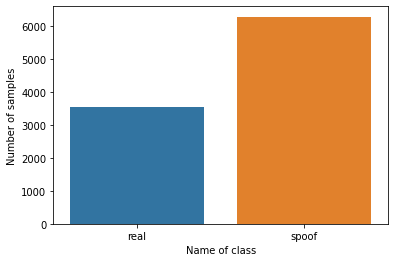

In [28]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

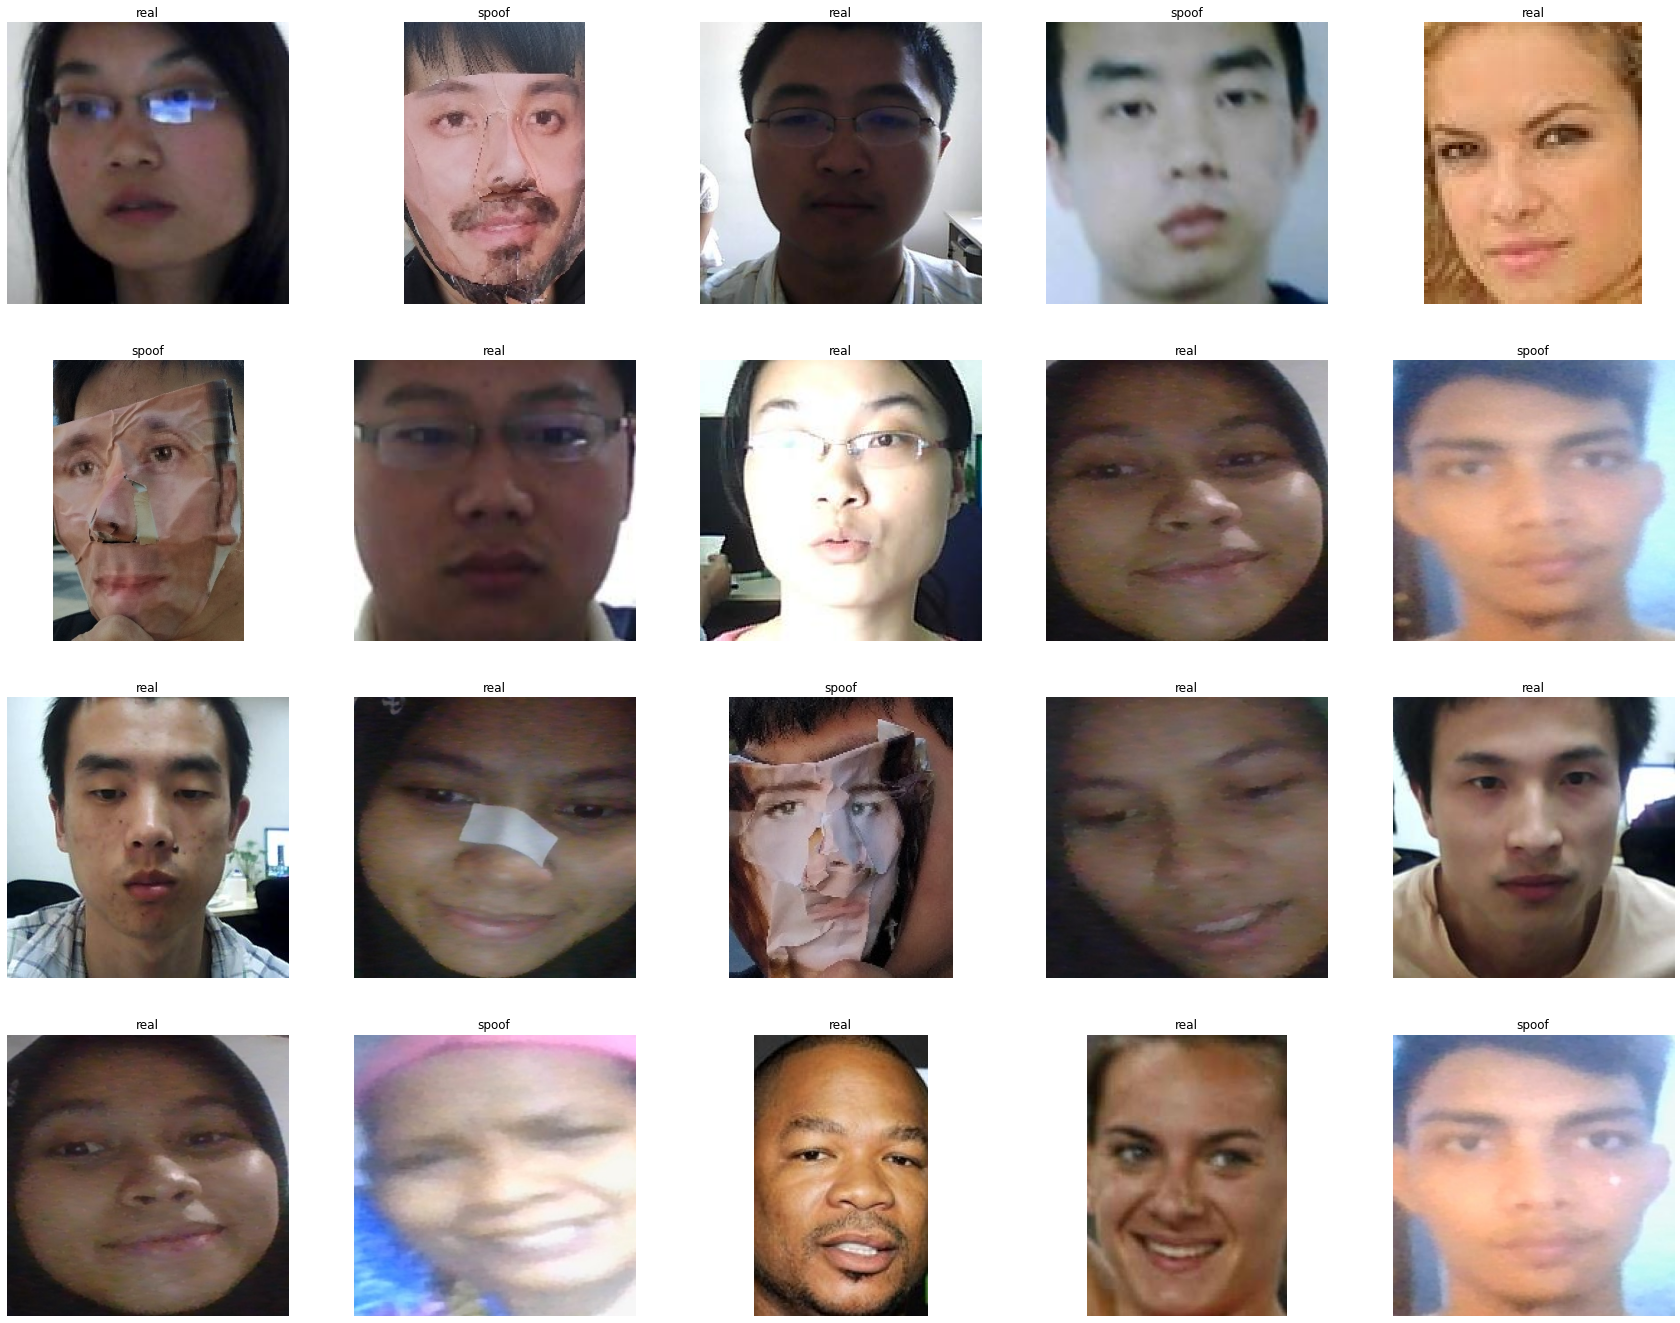

In [29]:
classes = os.listdir(path)

plt.figure(figsize=(30 , 30))
for x in range(20):
    i = random.randint(0,1)                    # getting the class
    images = os.listdir(path+'/'+classes[i])
    j = random.randint(0,100)                  # getting the image
    image = cv2.imread(path+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

In [30]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True, validation_split=0.2)

In [31]:
train_ds = image_datagen.flow_from_directory(
        path,
        subset='training',
        target_size=(323, 323),
        batch_size=32)

val_ds = image_datagen.flow_from_directory(
        path,
        subset='validation',
        target_size=(323, 323),
        batch_size=32)

Found 7877 images belonging to 2 classes.
Found 1969 images belonging to 2 classes.


In [32]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

In [33]:

xception = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(323, 323, 3)
)

for layer in xception.layers:
    layer.trainable = False

model = models.Sequential()
model.add(xception)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(2, activation='sigmoid', name='classification'))


In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 classification (Dense)      (None, 2)                 1026      
                                                                 
Total params: 21,911,594
Trainable params: 1,050,114
Non-trainable params: 20,861,480
__________________________________

In [35]:
#model.load.weights(checkpoint_filepath)
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
247/247 [==============================] - 1195s 5s/step - loss: 0.3122 - accuracy: 0.8617 - val_loss: 0.1977 - val_accuracy: 0.9319
Epoch 2/10
247/247 [==============================] - 31683s 129s/step - loss: 0.1960 - accuracy: 0.9199 - val_loss: 0.1817 - val_accuracy: 0.9360
Epoch 3/10
247/247 [==============================] - 1314s 5s/step - loss: 0.1656 - accuracy: 0.9294 - val_loss: 0.2061 - val_accuracy: 0.9182
Epoch 4/10
247/247 [==============================] - 2255s 9s/step - loss: 0.1502 - accuracy: 0.9388 - val_loss: 0.1420 - val_accuracy: 0.9507
Epoch 5/10
247/247 [==============================] - 2232s 9s/step - loss: 0.1413 - accuracy: 0.9449 - val_loss: 0.1406 - val_accuracy: 0.9502
Epoch 6/10
247/247 [==============================] - 1996s 8s/step - loss: 0.1266 - accuracy: 0.9464 - val_loss: 0.1360 - val_accuracy: 0.9518
Epoch 7/10
247/247 [==============================] - 2128s 9s/step - loss: 0.1170 - accuracy: 0.9518 - val_loss: 0.1238 - val_accura

62/62 [==============================] - 477s 8s/step - loss: 0.1121 - accuracy: 0.9634


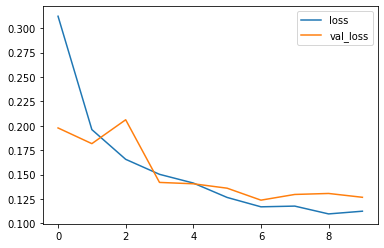

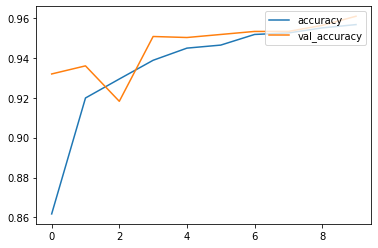

In [36]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

In [37]:
scores = model.evaluate(val_ds)
print("Validation loss:", scores[0])
print("Validation accuracy:", scores[1])

62/62 [==============================] - 503s 8s/step - loss: 0.1236 - accuracy: 0.9573
Validation loss: 0.1235981211066246
Validation accuracy: 0.9573387503623962


In [38]:
class_labels = train_ds.class_indices
print(class_labels)

{'real': 0, 'spoof': 1}


In [39]:
sub_csv ='Sample_submission.csv'
path_test = 'datasetmuka/andhar'

In [40]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [41]:
# each image will be treated individually and saved in a list which is then merged with the id of it's correspondence

from tensorflow.keras.preprocessing.image import load_img


# making a list for our predictions
labels = []


for i in range(1,17):
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(323, 323))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,323, 323,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


1/1 [==============================] - 1s 535ms/step


In [48]:
label
label_id = label[0].tolist()
print(label)
print(label_id)
print(label_id[0])

[[0.95275134 0.04987168]]
[0.9527513384819031, 0.04987167567014694]
0.9527513384819031


In [47]:
def determine_threshold(predictions, threshold):
    # Mengevaluasi probabilitas prediksi
    if predictions[0] >= threshold:
        class_prediction = 'real' # Klasifikasi ke kelas pertama
    else:
        class_prediction = 'spoof' # Klasifikasi ke kelas kedua
    
    return class_prediction

# Contoh penggunaan
predictions = [0.9527513384819031, 0.04987167567014694]  # Output model
threshold = 0.5  # Threshold yang digunakan

class_prediction = determine_threshold(label_id, threshold)
print("Klasifikasi prediksi:", class_prediction)

Klasifikasi prediksi: real


In [43]:
labels

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]

In [44]:
model.save('model_spoofing_1.h5')
